# Drift Report

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import display

try:
    # Functions to load and process data
    from data_pipeline import load_and_prepare_data, scale_data, prepare_xy_data
    
    # Functions for drift analysis
    from data_drift import get_feature_pvalues, get_feature_shift_status
except ImportError:
    print("Error: Make sure the .py files (data_pipeline.py, data_drift.py, etc.) are in the same directory as this notebook.")
    # In a real case, we would stop execution here or ask the user to place the files.
    # For this example, we will simulate that the import was successful.

# Visual configurations
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
print("Libraries and modules imported.")

Libraries and modules imported.


In [10]:
# Load and Features Configuration
DATA_CSV_PATH = 'data/wynn_daily_15y.csv'
FWD_RETURN_HORIZON = 5
LABEL_LOWER_Q = 0.2
LABEL_UPPER_Q = 0.8
SPLIT_RATIOS = {'train': 60, 'test': 20, 'validation': 20}

print("--- Starting Data Load and Preparation ---")
# 1. Load and Prepare Data (Step 1 from main.py13
# (We use the original DFs for the backtest, but here we need them for scaling)
train_df, test_df, validation_df = load_and_prepare_data(
    csv_path=DATA_CSV_PATH,
    horizon=FWD_RETURN_HORIZON,
    lower_q=LABEL_LOWER_Q,
    upper_q=LABEL_UPPER_Q,
    split_ratios=SPLIT_RATIOS
)

# 2. Scale Features (Step 2 from main.py14
# (These are the DFs we will use for the drift analysis)
train_scaled, test_scaled, val_scaled = scale_data(
    train_df, test_df, validation_df
)

# 3. Prepare X/y (Step 3 from main.py5]# (Mainly to get the final list of 'feature_cols')
_, _, _, _, _, _, feature_cols = prepare_xy_data(
    train_scaled, val_scaled, test_scaled
)

print("\n--- Data Ready for Drift Analysis ---")
print(f"Total features to analyze: {len(feature_cols)}")
print(f"Train shape (scaled): {train_scaled.shape}")
print(f"Test shape (scaled): {test_scaled.shape}")
print(f"Validation shape (scaled): {val_scaled.shape}")

# Prepare base dataframes for analysis (features only)
baseline_data = train_scaled[feature_cols]
test_data = test_scaled[feature_cols]
val_data = val_scaled[feature_cols]

--- Starting Data Load and Preparation ---
Total de Datos previo a drop: 3972
Datos NA después de Drop:
0
Total de Datos después de drop: 3926
Etiquetas generadas: 3921 
Total por clase:target
1    0.60010
2    0.19995
0    0.19995
Name: count, dtype: float64 


 
Escaladores aplicados a todos los conjuntos correctamente.
Shapes:
X_train: (2352, 33) | y_train: (2352,)
X_val: (785, 33) | y_val: (785,)
X_test: (784, 33) | y_test: (784,)

--- Data Ready for Drift Analysis ---
Total features to analyze: 33
Train shape (scaled): (2352, 36)
Test shape (scaled): (784, 36)
Validation shape (scaled): (785, 36)


In [11]:
# Generate Drift Statistics Table

print("Calculating p-values (Test vs. Train)...")
p_values_test = get_feature_pvalues(baseline_data, test_data)
shift_status_test = get_feature_shift_status(baseline_data, test_data, threshold=0.05)

print("Calculating p-values (Validation vs. Train)...")
p_values_val = get_feature_pvalues(baseline_data, val_data)
shift_status_val = get_feature_shift_status(baseline_data, val_data, threshold=0.05)

# Build the results table
drift_df = pd.DataFrame(index=feature_cols)
drift_df['p_value_test'] = drift_df.index.map(p_values_test)
drift_df['drift_detected_test'] = drift_df.index.map(shift_status_test)
drift_df['p_value_val'] = drift_df.index.map(p_values_val)
drift_df['drift_detected_val'] = drift_df.index.map(shift_status_val)

# Sort by the lowest p-value (highest drift)
drift_df = drift_df.sort_values(by='p_value_test', ascending=True)

print("\n--- Drift Statistics Table (Complete) ---")

display(drift_df.style.format({
    'p_value_test': '{:.4g}'.format,
    'p_value_val': '{:.4g}'.format
}))

Calculating p-values (Test vs. Train)...
Calculating p-values (Validation vs. Train)...

--- Drift Statistics Table (Complete) ---


,p_value_test,drift_detected_test,p_value_val,drift_detected_val
obv,1.531e-316,True,0,True
tr_norm,1.556e-121,True,5.89e-15,True
vol_sma_20,4.762e-66,True,2.266e-12,True
Low,1e-65,True,2.701e-172,True
Close,4.389e-65,True,1.547e-174,True
Open,1.71e-63,True,4.228e-175,True
High,4.429e-62,True,1.669e-178,True
atr_28,1.642e-45,True,6.706e-187,True
Volume,4.614e-38,True,0.001579,True
bb_width,1.894e-30,True,1.337e-07,True


In [12]:
# Highlighting - Show only features with drift
print(f"--- Highlighting: Features with Drift (Test vs Train) ---")
drifted_test = drift_df[drift_df['drift_detected_test'] == True]

display(drifted_test.style.format({
    'p_value_test': '{:.4g}'.format,
    'p_value_val': '{:.4g}'.format
}))


print(f"\n--- Highlighting: Features with Drift (Validation vs Train) ---")
drifted_val = drift_df[drift_df['drift_detected_val'] == True]

display(drifted_val.style.format({
    'p_value_test': '{:.4g}'.format,
    'p_value_val': '{:.4g}'.format
}))

--- Highlighting: Features with Drift (Test vs Train) ---


,p_value_test,drift_detected_test,p_value_val,drift_detected_val
obv,1.531e-316,True,0,True
tr_norm,1.556e-121,True,5.89e-15,True
vol_sma_20,4.762e-66,True,2.266e-12,True
Low,1e-65,True,2.701e-172,True
Close,4.389e-65,True,1.547e-174,True
Open,1.71e-63,True,4.228e-175,True
High,4.429e-62,True,1.669e-178,True
atr_28,1.642e-45,True,6.706e-187,True
Volume,4.614e-38,True,0.001579,True
bb_width,1.894e-30,True,1.337e-07,True



--- Highlighting: Features with Drift (Validation vs Train) ---


,p_value_test,drift_detected_test,p_value_val,drift_detected_val
obv,1.531e-316,True,0,True
tr_norm,1.556e-121,True,5.89e-15,True
vol_sma_20,4.762e-66,True,2.266e-12,True
Low,1e-65,True,2.701e-172,True
Close,4.389e-65,True,1.547e-174,True
Open,1.71e-63,True,4.228e-175,True
High,4.429e-62,True,1.669e-178,True
atr_28,1.642e-45,True,6.706e-187,True
Volume,4.614e-38,True,0.001579,True
bb_width,1.894e-30,True,1.337e-07,True


In [13]:
# Summary - Top 5 Features
top_5_drifted = drift_df.sort_values(by='p_value_test').head(5)
print("--- Summary: Top 5 Most-Drifted Features (Test vs. Train) ---")

display(top_5_drifted.style.format({
    'p_value_test': '{:.4g}'.format,
    'p_value_val': '{:.4g}'.format
}))

--- Summary: Top 5 Most-Drifted Features (Test vs. Train) ---


,p_value_test,drift_detected_test,p_value_val,drift_detected_val
obv,1.531e-316,True,0,True
tr_norm,1.556e-121,True,5.89e-15,True
vol_sma_20,4.762e-66,True,2.266e-12,True
Low,1e-65,True,2.701e-172,True
Close,4.389e-65,True,1.547e-174,True


In [14]:
df_train_plot = baseline_data.copy()
df_test_plot = test_data.copy()
df_val_plot = val_data.copy()

df_train_plot['Set'] = '1. Train'
df_test_plot['Set'] = '2. Test'
df_val_plot['Set'] = '3. Validation'

# Combine all into a single DataFrame
df_combined = pd.concat([df_train_plot, df_test_plot, df_val_plot])

print("Combined DataFrame for plots ready.")
display(df_combined.head())

Combined DataFrame for plots ready.


,Open,High,Low,Close,Adj Close,Volume,rsi_14,rsi_28,macd_12_26,macd_signal_12_26,...,donchian_width,tr_norm,obv,mfi_14,cmf_20,vol_sma_20,vol_zscore_20,vol_spike_ratio,vwap_dev,Set
46,-1.539059,-1.550752,-1.515037,-1.513654,-1.729496,-0.306476,0.808497,0.994892,0.362561,0.072187,...,-0.673634,0.045293,0.490611,1.731302,1.514791,0.074471,-0.804023,-0.478797,0.855914,1. Train
47,-1.499030,-1.518910,-1.491210,-1.506230,-1.724437,-0.335391,0.815636,0.997402,0.424312,0.148398,...,-0.639430,-0.004441,0.519530,1.745373,1.214017,0.026895,-0.793772,-0.553031,-0.114148,1. Train
48,-1.535348,-1.551805,-1.528959,-1.532745,-1.742503,-0.243663,0.747040,0.964102,0.442526,0.213245,...,-0.639430,0.025720,0.488188,1.344907,1.317510,-0.025582,-0.521818,-0.328336,0.302551,1. Train
49,-1.521033,-1.483120,-1.502454,-1.448956,-1.685416,0.560619,0.829633,0.993955,0.529217,0.283580,...,-0.510213,0.018240,0.540782,1.380296,1.500595,0.044329,1.184244,1.219122,1.966121,1. Train
50,-1.436467,-1.442857,-1.443823,-1.470699,-1.700229,0.455853,0.778210,0.967158,0.570223,0.348580,...,-0.364845,0.086165,0.490956,1.962703,1.190862,0.119856,0.861862,0.804569,-1.312338,1. Train


--- Plotting Distributions (Timeline View) for: ['obv', 'tr_norm', 'vol_sma_20', 'Low', 'Close'] ---


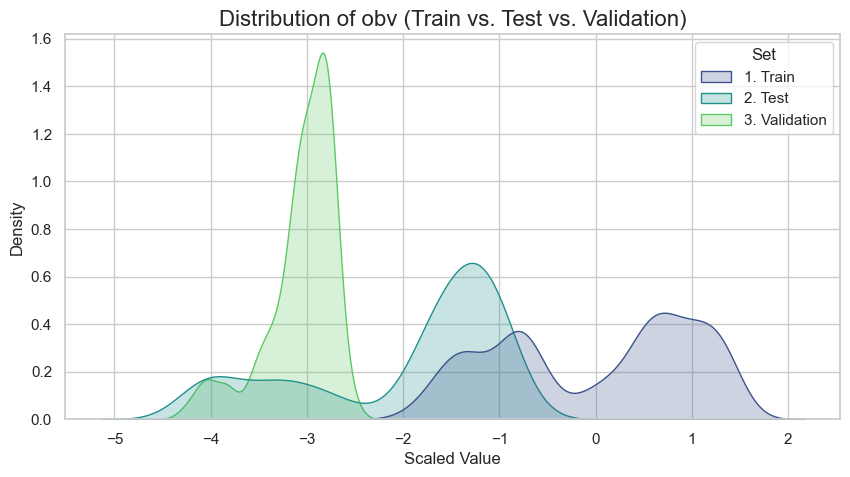

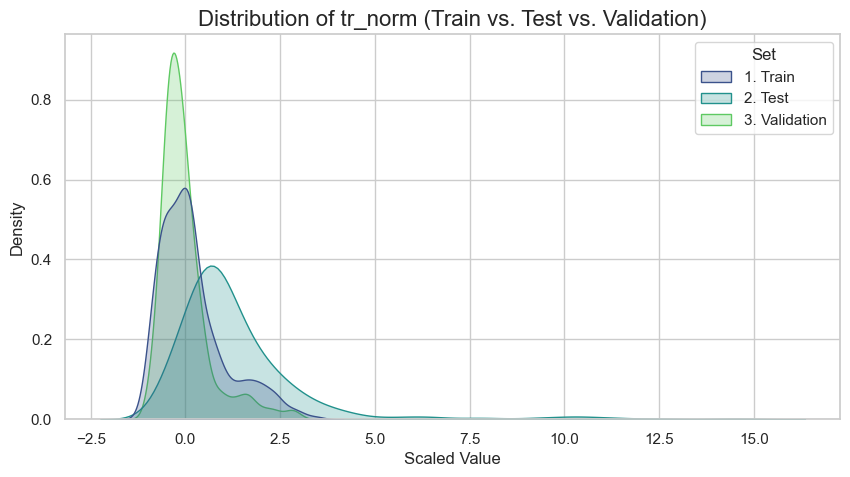

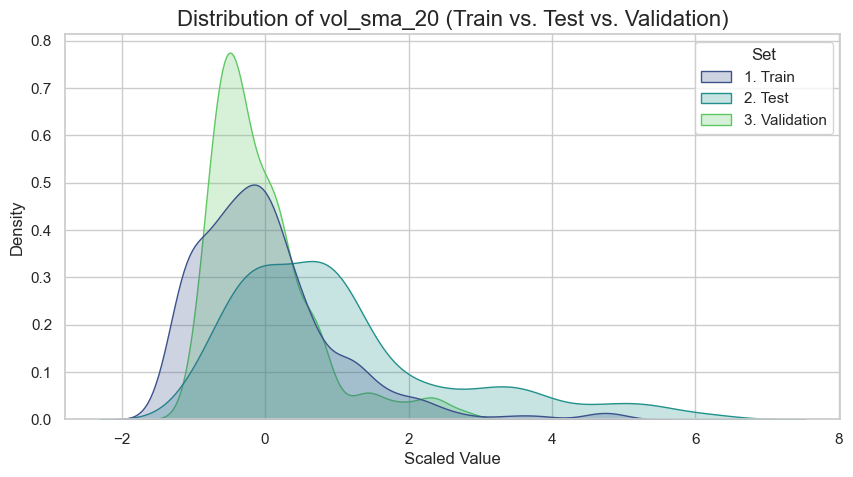

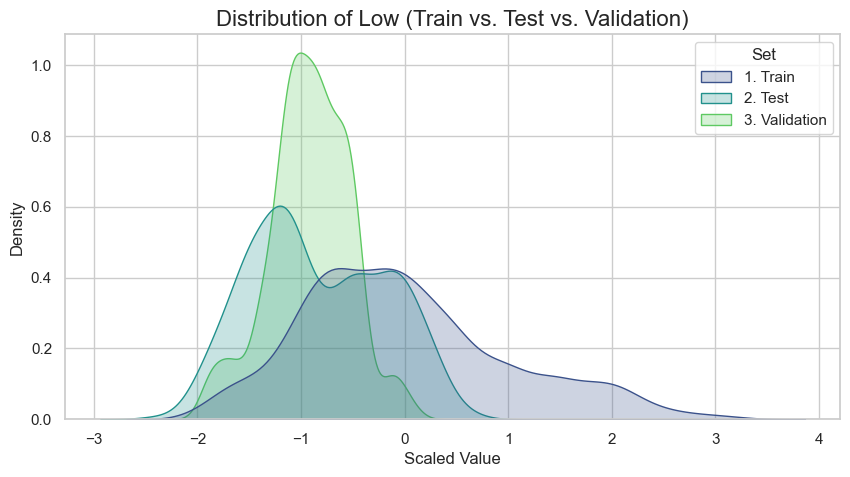

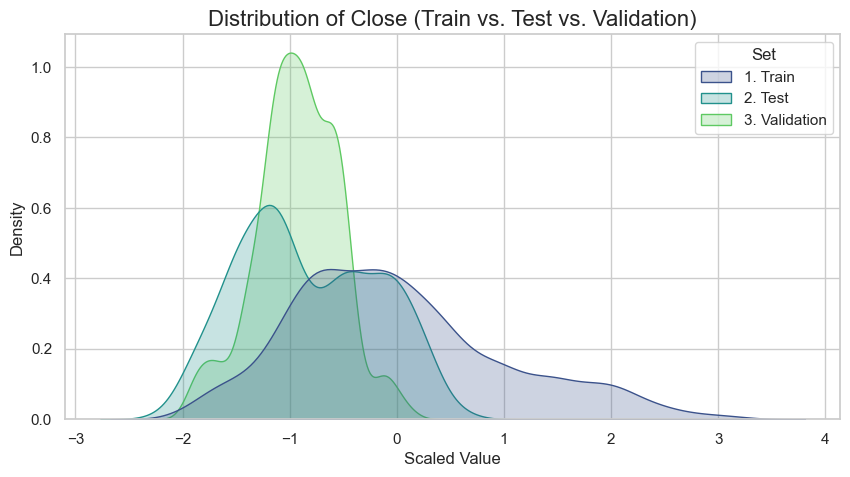

In [15]:
top_5_list = top_5_drifted.index.tolist()
print(f"--- Plotting Distributions (Timeline View) for: {top_5_list} ---")

for col in top_5_list:
    plt.figure(figsize=(10, 5))
    
    # We use kdeplot (Kernel Density Estimate) to see the distributions
    sns.kdeplot(
        data=df_combined, 
        x=col, 
        hue='Set', 
        fill=True, 
        common_norm=False, # Important: each curve is normalized independently
        palette='viridis'
    )
    
    plt.title(f'Distribution of {col} (Train vs. Test vs. Validation)', fontsize=16)
    plt.xlabel('Scaled Value')
    plt.ylabel('Density')
    
    plt.show()


--- Plotting ALL features ---


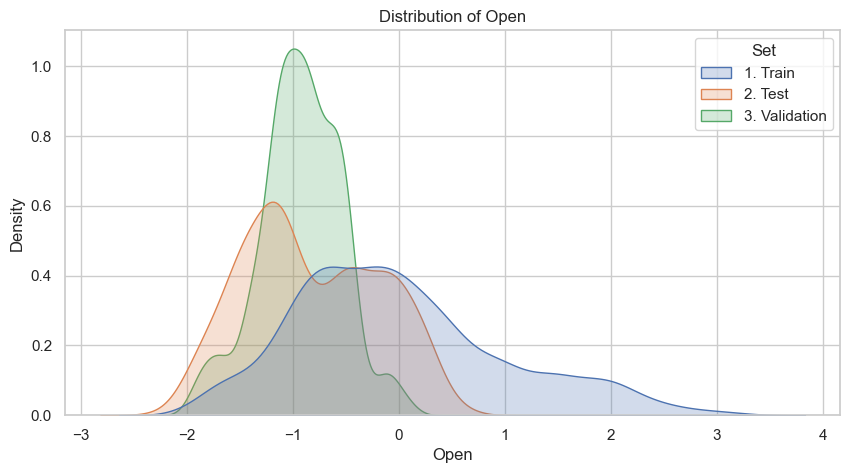

------------------------------


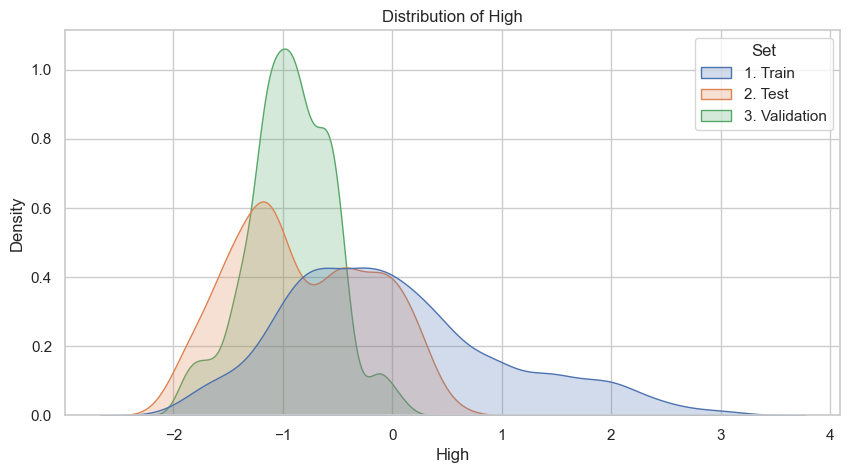

------------------------------


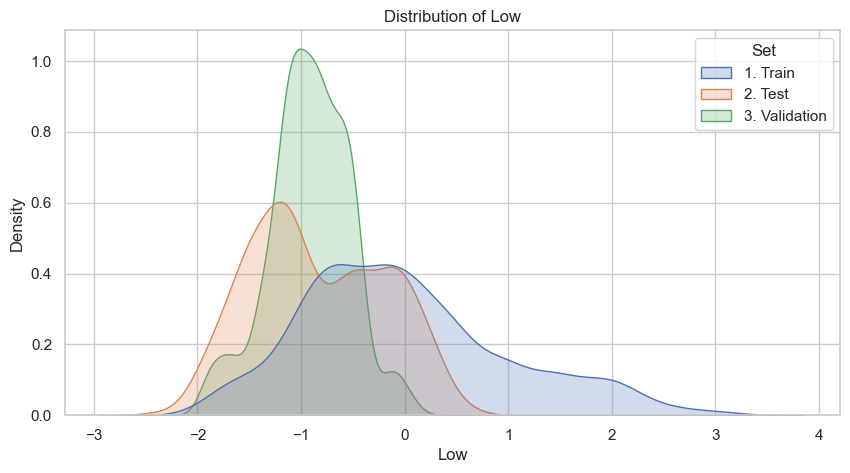

------------------------------


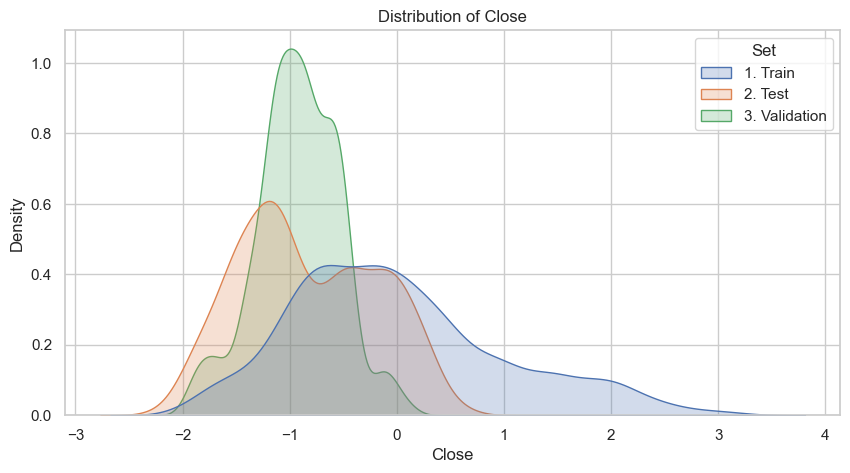

------------------------------


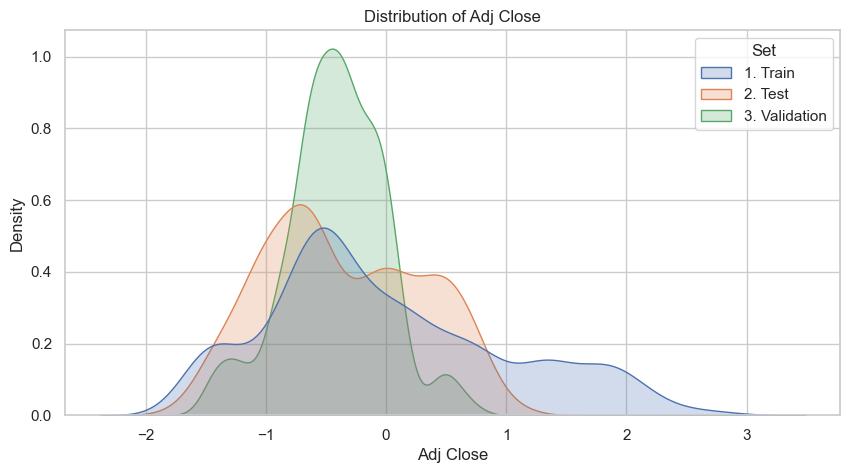

------------------------------


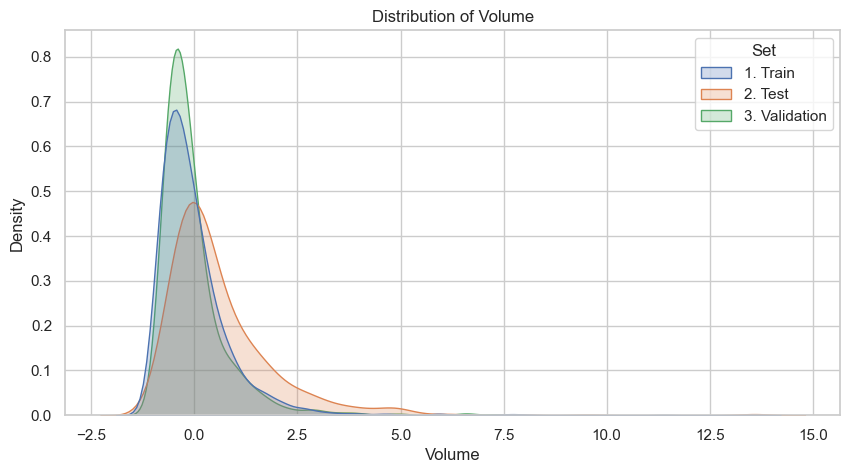

------------------------------


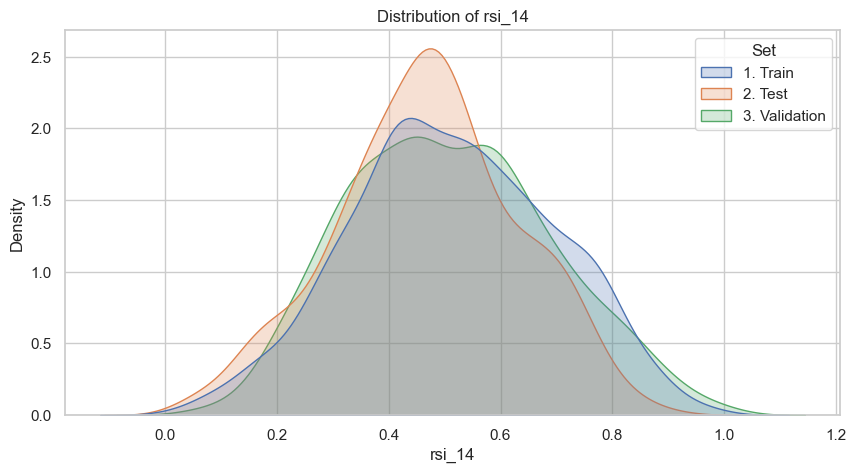

------------------------------


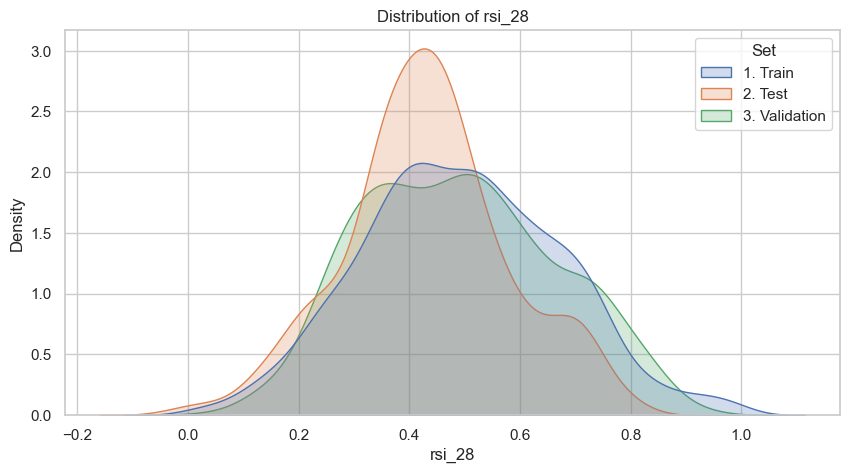

------------------------------


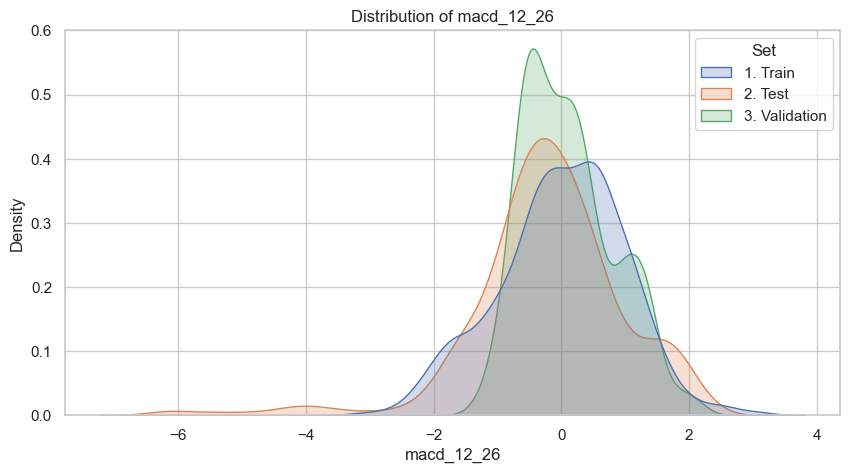

------------------------------


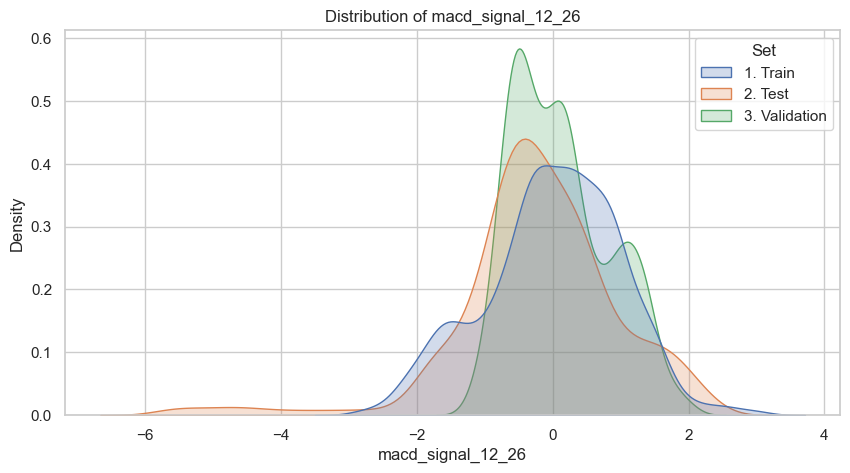

------------------------------


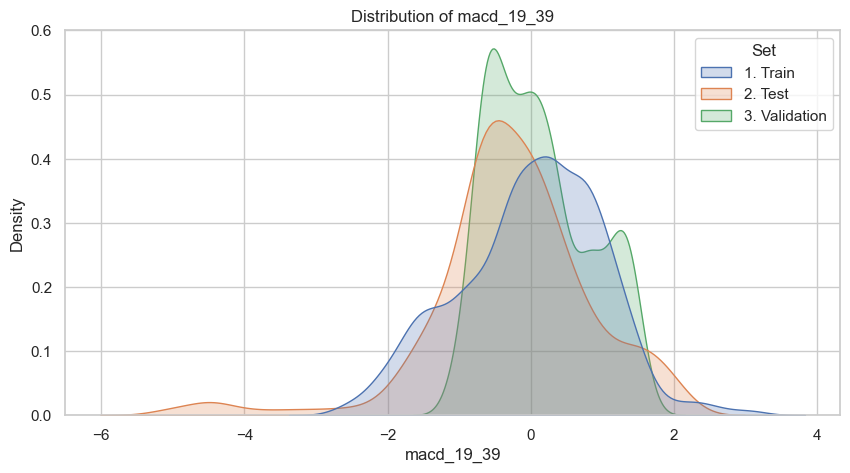

------------------------------


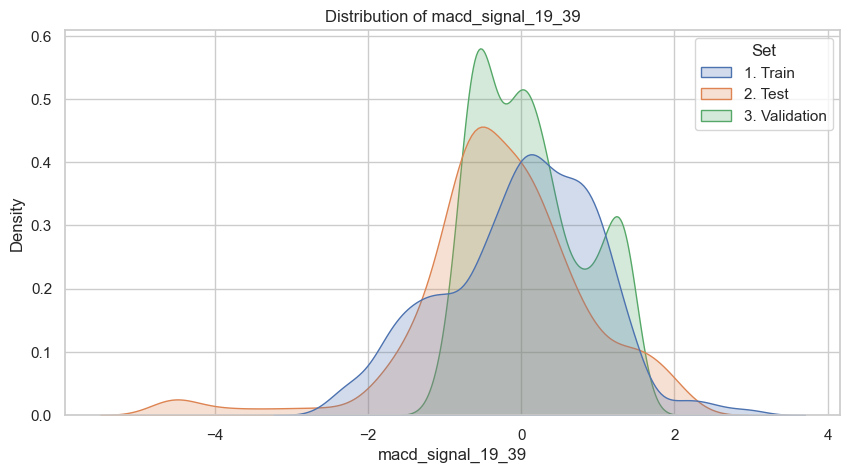

------------------------------


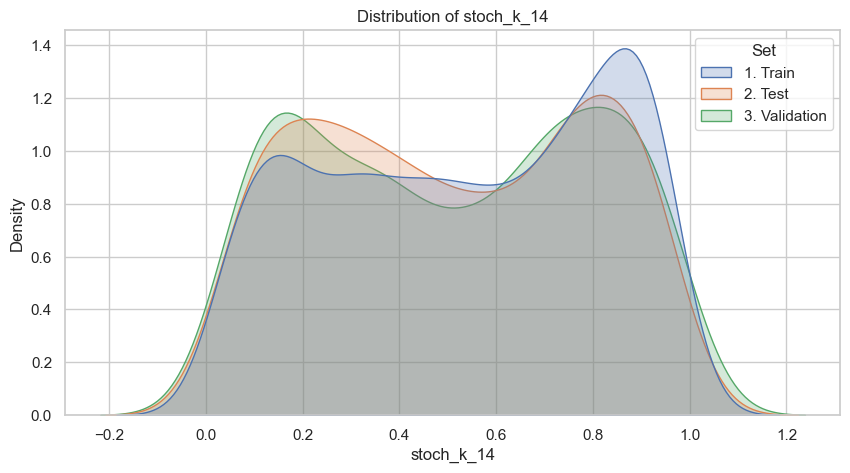

------------------------------


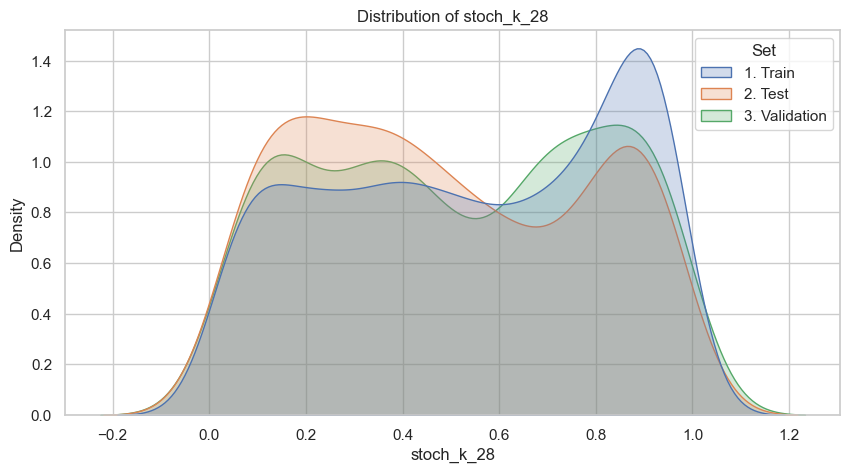

------------------------------


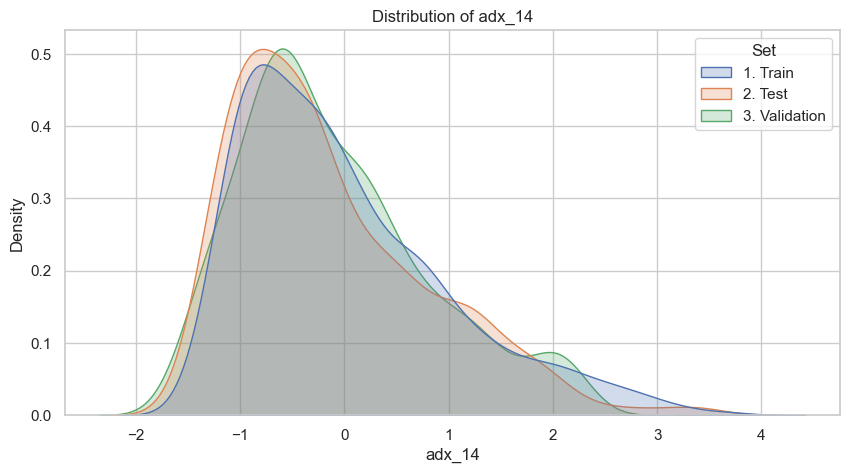

------------------------------


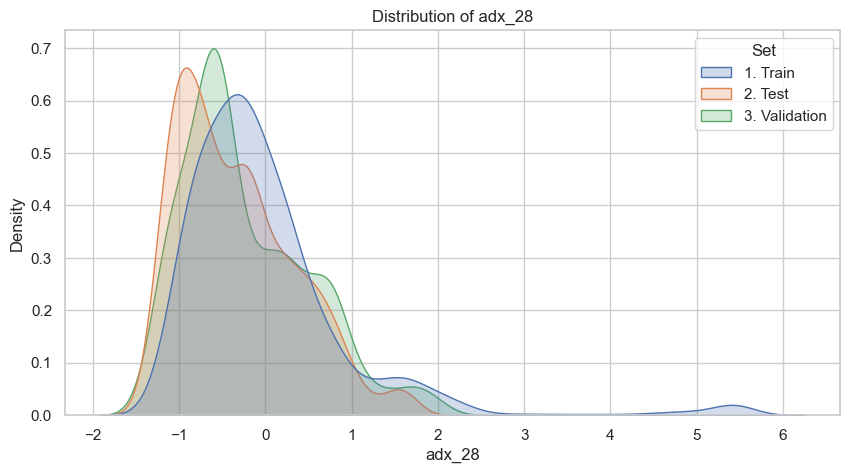

------------------------------


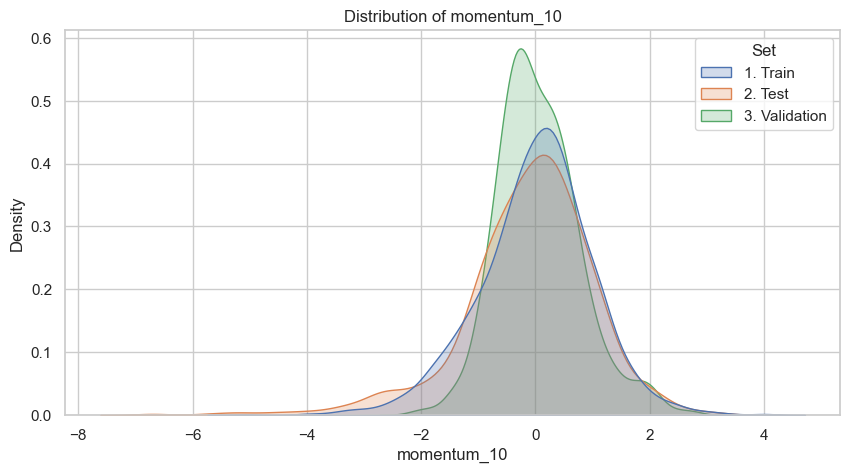

------------------------------


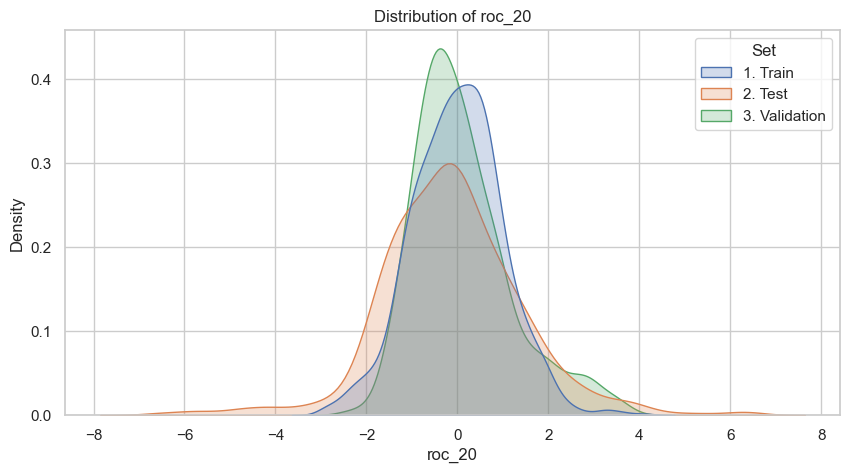

------------------------------


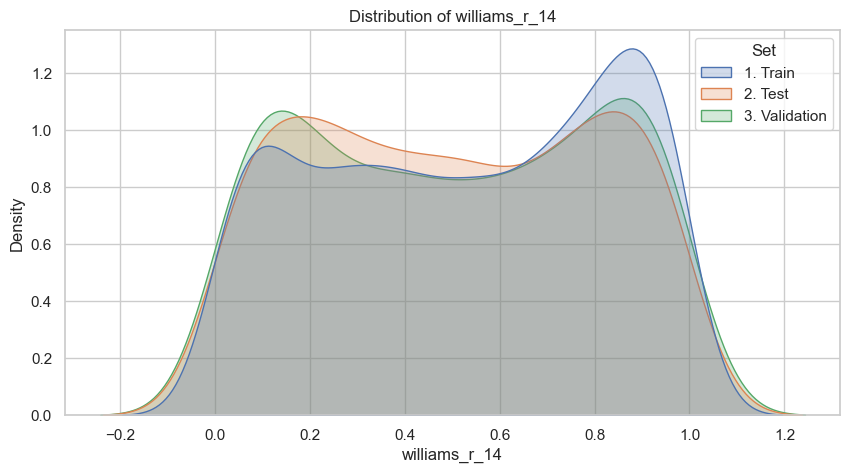

------------------------------


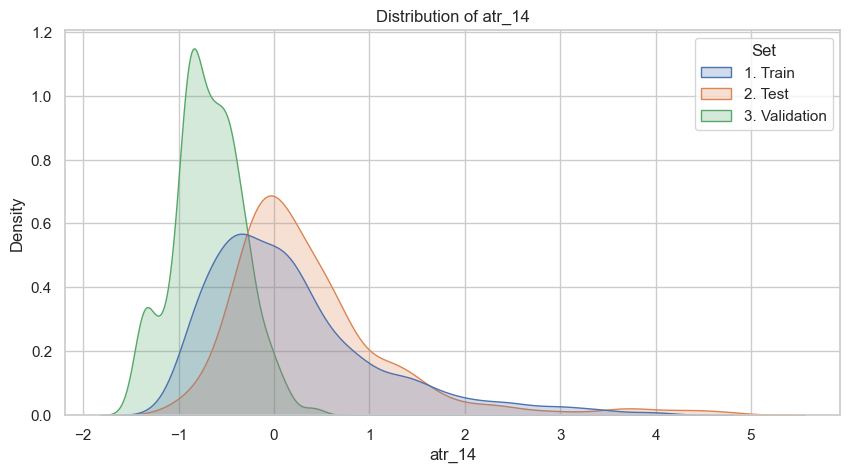

------------------------------


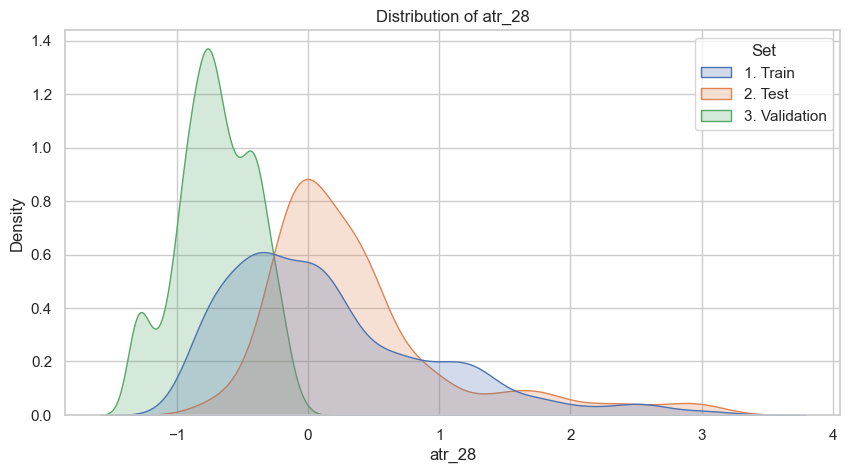

------------------------------


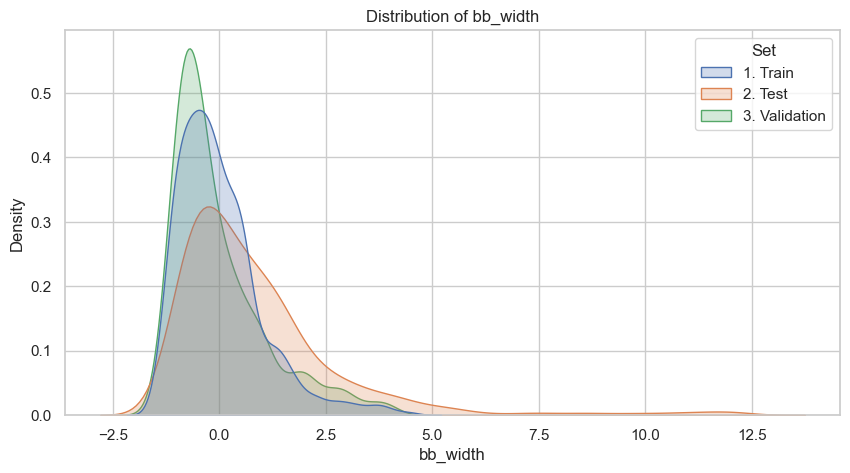

------------------------------


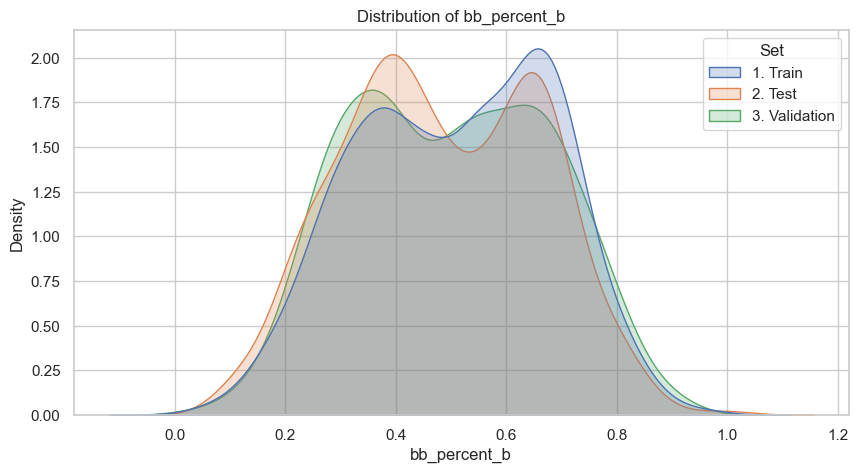

------------------------------


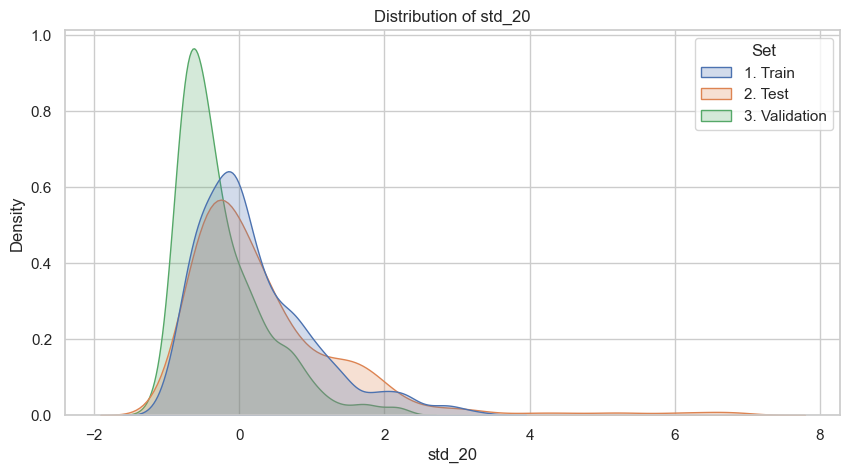

------------------------------


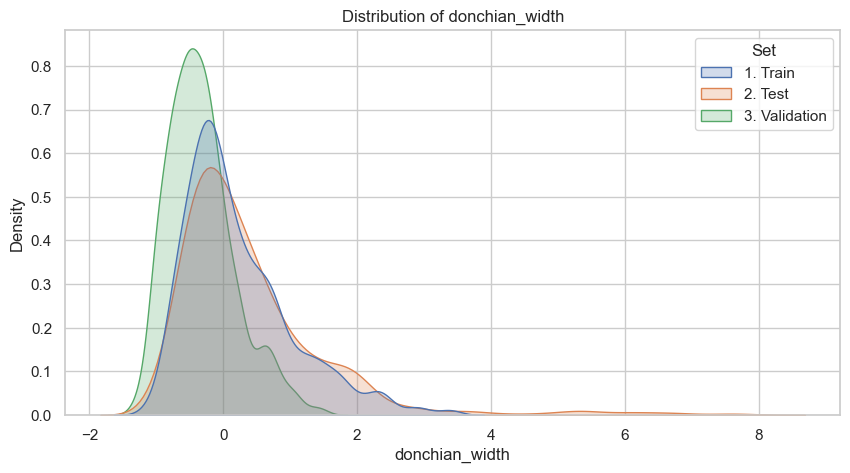

------------------------------


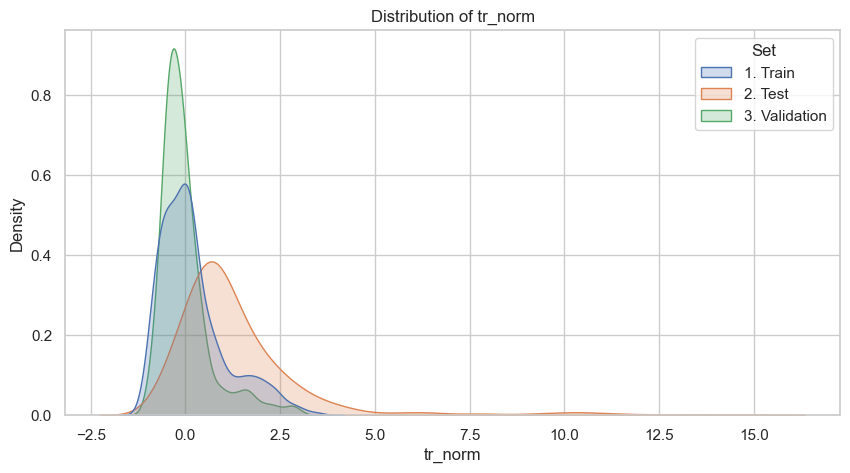

------------------------------


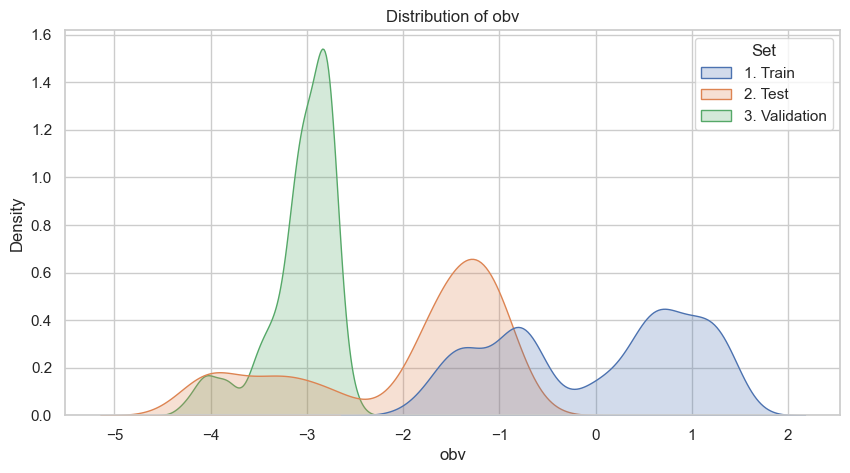

------------------------------


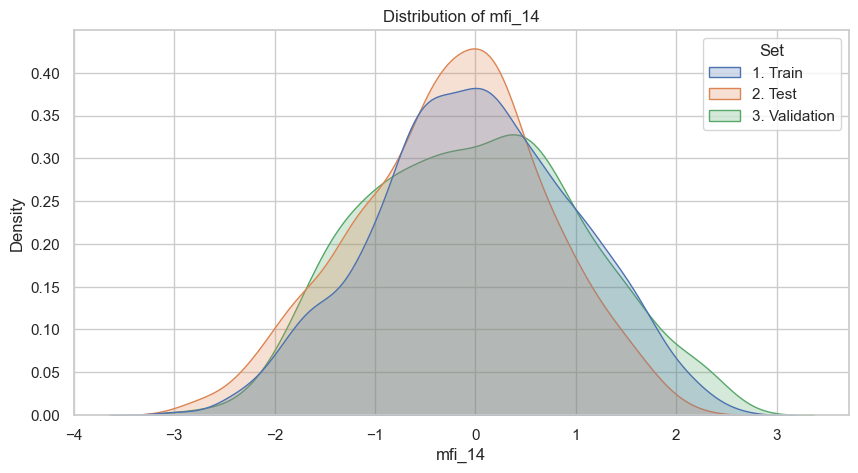

------------------------------


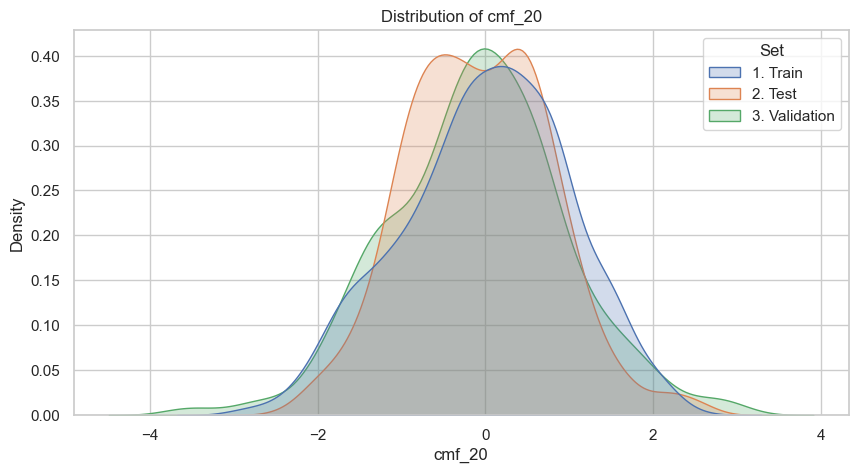

------------------------------


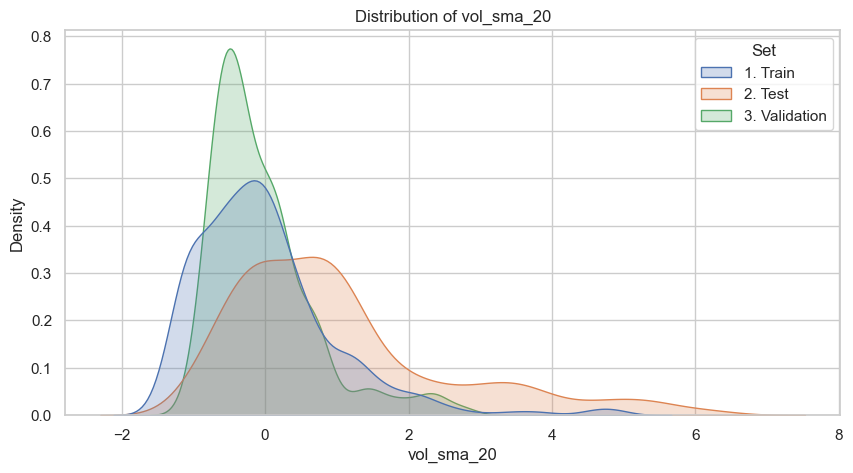

------------------------------


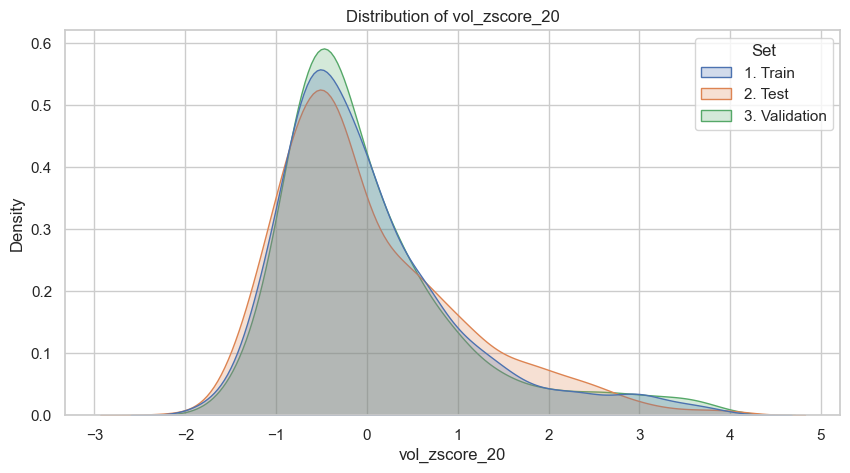

------------------------------


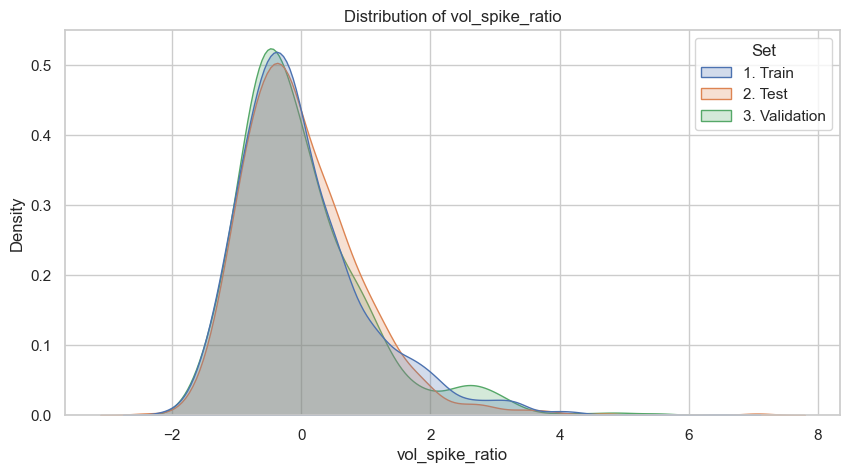

------------------------------


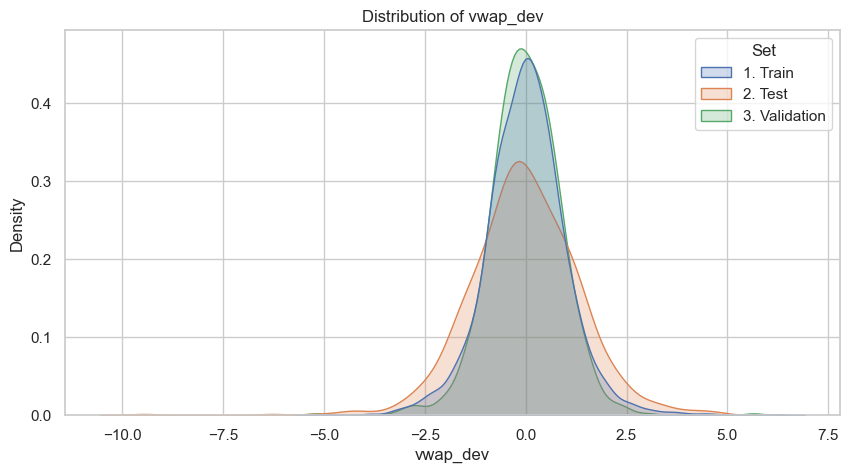

------------------------------


In [16]:
# Plot ALL features
print("\n--- Plotting ALL features ---")
for col in feature_cols:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df_combined, x=col, hue='Set', fill=True, common_norm=False)
    plt.title(f'Distribution of {col}')
    
    plt.show()
    print("-" * 30)